In [5]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import wordle as wd


%load_ext autoreload
%autoreload 2

DATA_PATH = Path("../data/")
ALLOWED_WORDS_FNAME = "raw/allowed_words.txt"
POSSIBLE_WORDS_FNAME = "raw/possible_words.txt"
WORDS_PAIRS_FNAME = "transformed/guess_solution_map_{version}.pkl"
IMG_PATH = Path("../images/")

WORD = "crepe"

# Wordle Solver
## Goal
* build an agent that can play Wordle, with the goal to maximize its score on a given evaluation set.

## Heuristic
* use $entropy=-\sum p * log_2(p)$ to calculate by how much a given guess is expected to reduce the number of possible choices (wegihted average)
* v1: no prior on what are actual possible solutions
* v2: using knowledge about actual possible words
* v3: add 2 step look-ahead (consider expected entropy given best next guess following original one and guess outcome)

# Setup Game Engine
* game rules encapsulated in `WordleGame` class
* color-coded HTML display of guess outcome: `display_wordle_guess_outcome`
* basic function to validate whether a guess is possible: `is_word_possible_given_guess_outcome`


In [2]:
game = wd.WordleGame("crate")
outcome = game.evaluate_guess("treta")
wd.display_wordle_guess_outcome(outcome)
candidate_word = "areti"
print(f"candidate word: {candidate_word}")
wd.valid.is_word_possible_given_guess_outcome(candidate_word, outcome)

candidate word: areti


(False, 'OOP letter `E` should have different position')

## play a game manually

In [3]:
def make_guess(guess):
    guess_outcome = game.record_player_guess(guess)
    wd.display_wordle_guess_outcome(guess_outcome)
    if game.is_over:
        print("the game is over!")
        if game.solved:
            print(f"you won in {game.number_of_guesses} guesses")
        else:
            print(f"you have used your {game.max_guesses} guesses.")

In [19]:
# `word` has been defined in first notebook cell
game = wd.WordleGame(WORD)
while not game.is_over:
    guess = input("make a 5 letter guess:")
    make_guess(guess)

the game is over!
you won in 2 guesses


## load allowed words

In [13]:
# 5-letter words that are allowed to use as a guess
allowed_words = wd.load.load_words_as_dict(DATA_PATH / ALLOWED_WORDS_FNAME)

# possible words: actual possible solutions (a subset of 2.9k words of allowed words)
possible_words = wd.load.load_words_as_list(DATA_PATH / POSSIBLE_WORDS_FNAME)

# EDA

In [14]:
# number of allowed 5 letter words
five_letter_words = pd.Series(allowed_words.keys())
len(five_letter_words)

12953

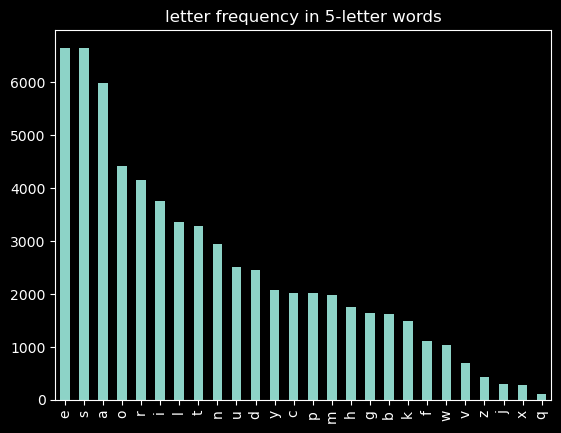

In [15]:
# letter prevalence as a whole
(five_letter_words
    .apply(lambda x: list(x))
    .explode()
    .value_counts()
    .plot(
        kind="bar",
        title="letter frequency in 5-letter words",
        ));

<Axes: title={'center': 'How often does a letter appear in a 5 letter word?'}>

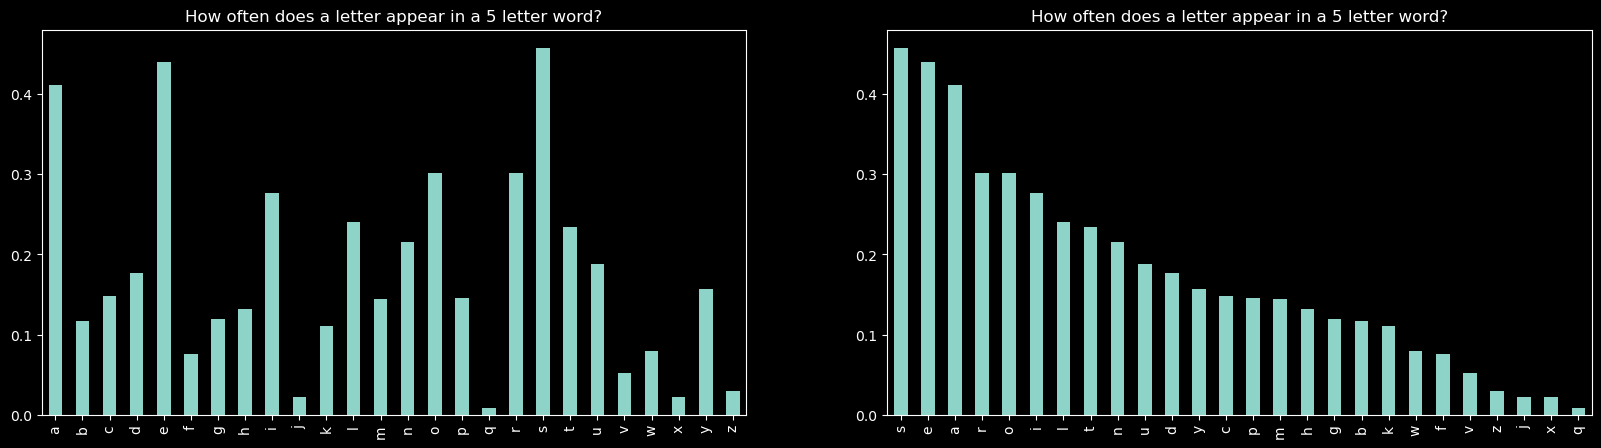

In [16]:
ALPHABET = "abcdefghijklmnopqrstuvwxyz"
# how often does a letter appear in a 5 letter word?
letter_frequency = pd.Series({letter: five_letter_words.str.contains(letter).mean() for letter in ALPHABET})

fig, ax = plt.subplots(1,2, figsize=(20,5))
letter_frequency.plot.bar(title="How often does a letter appear in a 5 letter word?", ax=ax[0])
letter_frequency.sort_values(ascending=False).plot.bar(title="How often does a letter appear in a 5 letter word?", ax=ax[1])

## Building a map of possible solutions given a guess outcome
We can pre-compute the outcome you would get if you enter a certain guess word, given a specific solution word. this can be stored in the form of a ($n_{possible solutions} x n_{allowed words} numpy array) which we call a`PossibleSolutionsMap`. outcomes are stored as uint8 to reduce the size of this map (cf. bonus)
### v1: no prior assumption about actual possible solutions
* no integration of word likelihood based on word popularity (all words in dic have same probability = 1)
* no integration of prior knowledge about possible solutiosn (aka `possible_words`)
* one step ahead lookup

In [9]:
psm = wd.PossibleSolutionsMap(allowed_words, list(allowed_words))
%time psm.build_map()
print(psm)

%time psm.to_pickle(DATA_PATH / WORDS_PAIRS_FNAME.format(version="v1"))

  0%|          | 0/12953 [00:00<?, ?it/s]

CPU times: user 24min 39s, sys: 45.1 s, total: 25min 24s
Wall time: 25min 1s
PossibleSolutionsMap(n_solutions=12953,n_allowed=12953,entropy=13.66)
CPU times: user 12.1 ms, sys: 41.2 ms, total: 53.3 ms
Wall time: 62.9 ms


### v2: using prior knowledge about actual possible words

In [10]:
psm_v2 = wd.PossibleSolutionsMap({word: 1.0 for word in possible_words}, list(allowed_words))
%time psm_v2.build_map()
print(psm_v2)

%time psm_v2.to_pickle(DATA_PATH / WORDS_PAIRS_FNAME.format(version="v2"))

  0%|          | 0/2309 [00:00<?, ?it/s]

CPU times: user 4min 25s, sys: 9.94 s, total: 4min 35s
Wall time: 4min 30s
PossibleSolutionsMap(n_solutions=2309,n_allowed=12953,entropy=11.17)
CPU times: user 3.23 ms, sys: 7.96 ms, total: 11.2 ms
Wall time: 12.4 ms


## Reload

In [2]:
# reload
psm = wd.PossibleSolutionsMap.from_pickle(DATA_PATH / WORDS_PAIRS_FNAME.format(version="v1"))
psm_v2 = wd.PossibleSolutionsMap.from_pickle(DATA_PATH / WORDS_PAIRS_FNAME.format(version="v2"))

In [11]:
def simulate_game_so_far(solution: str, guesses: list[str]):
    game = wd.WordleGame(solution)
    for guess in guesses:
        game.record_player_guess(guess)
        wd.display_wordle_guess_outcome(game.guesses_so_far[-1])
    
    return game

## test performance with caching of entropies calculation for all candidates

In [13]:
# game start: all words are possible solutions (map = 13k x 13k)
%time candidate_entropies = wd.player.get_all_candidate_entropies(psm)
%time candidate_entropies = wd.player.get_all_candidate_entropies(psm)

# after one guess: 
%time candidate_entropies = wd.player.get_all_candidate_entropies(psm_v2)

CPU times: user 12.1 s, sys: 2.19 s, total: 14.3 s
Wall time: 15.2 s
CPU times: user 520 µs, sys: 26 µs, total: 546 µs
Wall time: 549 µs
CPU times: user 3.28 s, sys: 207 ms, total: 3.49 s
Wall time: 3.58 s


## Players
### Test GreedyPlayer
* maximizing expected information gain for the next step

In [18]:
player = wd.player.GreedyPlayer(psm)
game = wd.WordleGame("round")
%time wd.player.play_game(player, game=game)



CPU times: user 9.42 s, sys: 169 ms, total: 9.59 s
Wall time: 9.6 s


WordleGame(target_word='ROUND', max_guesses=6, number_of_guesses=3, is_over=True, solved=True)

# Visualizing outcome distributions
## best starter guesses

In [19]:
wd.player.get_all_candidate_entropies(psm_v2).head(5)

soare    5.885203
roate    5.884856
raise    5.878303
reast    5.867738
raile    5.865154
dtype: float64

In [20]:
wd.display.plot_distrib("soare", psm)

Comments: no outcome is more than 8% likely to happen.
## worst starting guesses

In [15]:
wd.player.get_all_candidate_entropies(psm_v2).tail(5)

yukky    2.205343
xylyl    2.189638
immix    2.055325
jujus    2.039470
qajaq    1.890193
dtype: float64

In [124]:
wd.display.plot_distrib("yukky", psm)

**Comments**: the distribution is very unbalanced with almost 60% chance to get zero letters matching and the two next outcomes being matched by over 10% of the possible solutions.

# Evaluation
* **goal**: maximize average score

In [3]:
def run_eval(config) -> tuple[wd.eval.EvalResults, go.Figure]:

    wd.player.get_all_candidate_entropies.cache_clear()
    eval_words_list = wd.load.load_words_as_list(config["path_to_eval_words_list"])
    
    results = wd.eval.eval_player(
        eval_words_list, 
        config["player"], 
        pool_size=1)

    # save results
    results.to_json(config["path_to_json_output"])
    print(f"results saved in `{config['path_to_json_output']}`")

    fig = results.barplot(title=config["fig_title"])
    fig.write_image(config["fig_name"])

    return results, fig

## Evaluating v1
* no prior knowledge of exact list of possible solutions

In [47]:
config = {
    "player": wd.player.GreedyPlayer(starting_psm=psm),
    "path_to_eval_words_list": DATA_PATH / "raw/possible_words.txt",
    "path_to_json_output": DATA_PATH / "outputs/eval_results_v1.json",
    "fig_title": "v1 - no prior on potential solutions",
    "fig_name": IMG_PATH / "eval_v1.png",
}

res, fig = wd.eval.run_eval_from_config(config)

EvalResults(size=2,309, avg_score=2.99, dist=[   0   22  414 1443  425    5    0], success_rate=100.0%)
results saved in `../data/outputs/eval_results_v1.json`


## Evaluating v2 
* prior knowledge about exact list of potential solutions
* one-step entropy calculation

In [ ]:
config = {
    "player": wd.player.GreedyPlayer(starting_psm=psm),
    "path_to_eval_words_list": DATA_PATH / "raw/possible_words.txt",
    "path_to_json_output": DATA_PATH / "outputs/eval_results_v2.json",
    "fig_title": "v2 - strong prior on potential solutions",
    "fig_name": IMG_PATH / "eval_v2.png",
}

results_v2, fig = wd.eval.run_eval_from_config(config)



EvalResults(size=2,309, avg_score=3.47, dist=[   0    1   67 1111 1098   32    0], success_rate=100.0%)
CPU times: user 48min 30s, sys: 33.9 s, total: 49min 4s
Wall time: 3h 27min 39s


### v2 - words with highest and lowest scores

In [161]:
player = wd.player.GreedyPlayer(psm_v2)
scores = pd.Series(results_v2.scores).sort_values(ascending=False)
scores.head()

ovate    5
chaos    5
arson    5
bravo    5
adore    5
dtype: int64

In [162]:
wd.play_game(player, wd.WordleGame("chaos"))

WordleGame(target_word='CHAOS', max_guesses=6, number_of_guesses=2, is_over=True, solved=True)

### lowest scores for v2

In [163]:
# lowest scores
scores.tail()

cover    2
witty    2
fever    2
parer    2
waver    1
dtype: int64

In [120]:
wd.player.play_game(player, wd.WordleGame("waver"))

WordleGame(target_word='WAVER', max_guesses=6, number_of_guesses=6, is_over=True, solved=True)

## Adding v3: two-step information gain maximization
2-step look ahead: cumulate entropy from best next guess with entropy from first guess
* if two words have equal expected information gain, the one with highest step 1 information gain is prioritized

### Pseudo-Code for 2-steps player
#### Vanilla version
* for each allowed word to guess $guess_1$(x13k)
    * for each possible guess outcome (x~200)
        * generate next step psm 
        * for each allowed word for second guess (x 13k)
            * calculate expected information gain based on next step psm
        * retrieve $max_{guess_2} E[I_2 | guess_2]$ 
    * $E[I_2 | guess_1] = \sum p(outcome) * max E[I_2 | outcome]$ 
* best guess is guess1 maximizing  $E[I_1 | guess_1] + E[I_2 | guess_1]$

#### Approximation
The above version is too compute intensive. we therefore propose the following approximation. 
 
**Assumption**: guess words that have high 2 steps score are among the top ranked 1 step guess words.
Under this assumption, we can limit the number of calculations by only calculating 2nd step information gain for the guess words top ranked under the first step.
The pseudo code then becomes:

* for each allowed word to guess $guess_1$(x13k)
    * calculate $E[I_1 | guess_1]$, the expected information gain after a single step
* keep the K top ranked guess words under this metric.
* for each of those K words: (x K)
    * for each possible guess outcome (x~200)
        * generate next step psm 
        * for each allowed word for second guess (x 13k)
            * calculate expected information gain based on next step psm
        * retrieve $max_{guess_2} E[I_2 | guess_2]$ 
    * $E[I_2 | guess_1] = \sum p(outcome) * max E[I_2 | outcome]$ 
* best guess 1 must maximize:  $E[I_1 | guess_1] + E[I_2 | guess_1]$

with $K=100$, this approx already reduces by 130 the computation cost


### what is the best starting word to maximize two-step entropy
* get top 50 top words based on single step information gain
* calculate 2 step entropy for those 50 words

In [ ]:
K = 100 # top words in terms of one-step expected information gain. 
# only those will get expected 2 step information gain calculated.
tsp = wd.player.TwoStepPlayer(psm_v2, max_first_guesses=K)
tse = tsp.calculate_two_step_entropies(show_tqdm=True)
tse.to_csv(DATA_PATH / "transformed/two_step_entropy_v2.1.csv")

In [ ]:
tse.head(15)

,entropy_step_1,entropy_step_2,entropy_total
guess_word,,,
slane,5.768957,4.267461,10.036419
slate,5.855819,4.175947,10.031766
salet,5.836023,4.180909,10.016932
trace,5.830429,4.182702,10.013131
crate,5.835216,4.177358,10.012574
reast,5.867738,4.143463,10.011201
carle,5.769364,4.236674,10.006038
carte,5.795107,4.201878,9.996985
torse,5.726483,4.270113,9.996596


**conclusion**: `slane` seems to be the best starting word, to maximize two-step expected information gain.  
Top ranking seems consistent with https://www.3blue1brown.com/lessons/wordle2 findings.

### comparing 1-step vs 2-steps top starting words ranking
* what is a reasonable $K$ for the approximate optimization described above?

In [89]:
# goal create table with words rank for 1-step vs 2-steps
df = pd.DataFrame({
    "word": tse.index,
    "2-steps rank": np.arange(0,len(tse)),  
})
df["1-step rank"] = df.word.map({word: i for i, word in enumerate(tse.entropy_step_1.sort_values(ascending=False).index)})

**Conclusion**: 
the figure does show a correlatin between 1-step and 2-steps rank.
$K=50$ seems like a reasonable assumption as all top 10 words based on 2 step rank were ranked in the top 50 when only considering one step.

### comparing 1-step vs 2-steps entropies

In [103]:
fig = px.scatter(
    tse.reset_index().rename({"entropy_step_1": "1-step entropy", "entropy_total": "2-steps entropy"}, axis=1), 
    x="1-step entropy", 
    y="2-steps entropy", 
    template="plotly_dark", 
    hover_data=["1-step entropy", "2-steps entropy", "guess_word"],
    title="1-step vs 2-steps entropies")
fig.show()
fig.write_image(IMG_PATH / "1_vs_2_steps_entropy_comparison.png")

### Play game with TwoStepPlayer

In [38]:
K = 20
tsp = wd.player.TwoStepPlayer(psm_v2, starting_guess="slane", max_first_guesses=K)
game = wd.WordleGame("maker")
tsp.start_new_game()
wd.player.play_game(tsp, game, quiet=False)

WordleGame(target_word='MAKER', max_guesses=6, number_of_guesses=3, is_over=True, solved=True)

In [39]:
tsp = wd.player.GreedyPlayer(psm_v2)
game = wd.WordleGame("maker")
tsp.start_new_game()
wd.player.play_game(tsp, game, quiet=False)

WordleGame(target_word='MAKER', max_guesses=6, number_of_guesses=4, is_over=True, solved=True)

## Evaluating v3


In [ ]:
config = {
    "player": wd.player.TwoStepPlayer(
        starting_psm=psm_v2, 
        starting_guess="slane", 
        max_first_guesses=20),
    "path_to_eval_words_list": DATA_PATH / "raw/possible_words.txt",
    "path_to_json_output": DATA_PATH / "outputs/eval_results_v3.json",
    "fig_title": "v3 - strong prior on potential solutions + 2 step look-ahead",
    "fig_name": IMG_PATH / "eval_v3.png",
}

results_v3, fig = wd.eval.run_eval_from_config(config)

EvalResults(size=2,309, avg_score=3.47, dist=[   0    0   39 1174 1057   39    0], success_rate=100.0%)
results saved in `../data/outputs/eval_results_v3.json`


## Confusion matrix between v2 and v3

In [ ]:
# reload
results_v2 = wd.eval.EvalResults.from_json("../data/outputs/eval_results_v2.json")
results_v3 = wd.eval.EvalResults.from_json("../data/outputs/eval_results_v3.json")

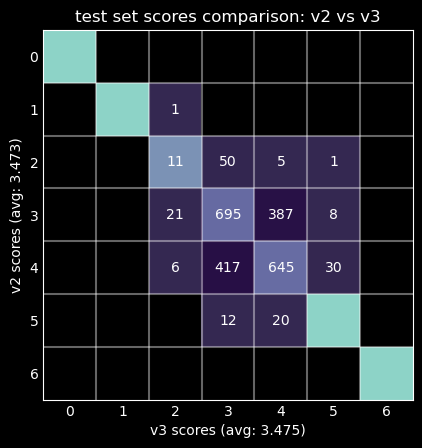

In [ ]:

cm_fig = wd.display.plot_confusion_matrix(results_v2, results_v3, "v2", "v3")

plt.savefig(IMG_PATH / "confusion_matrix_1_vs_2_steps.png");

### Observations
The current implementation of the TwoStep look-ahead does not seem to bare much fruits.
It is much more computationally expensive, and delivers no significant improvement vs the one-step `GreedyPlayer`.


## TO DO
- [x] create full player with greedy approach on entropy-minimizing strategy
- [x] create evaluation suite
    - play games with all possible_words
    - record number of guesses
    - generate averages
- [x] evaluation result visualization
- [x] refactor word distrib visualization
- [x] add improvement with non uniform entropies
- [x] add 2 steps look-ahead player
- [x] limit the number of first guesses to evaluate second guess to increase speed.
- [x] write summary in README file